In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import adabmDCA

from adabmDCA.fasta import get_tokens, import_from_fasta, compute_weights
from adabmDCA.stats import get_freq_single_point, get_freq_two_points
from adabmDCA.functional import one_hot
from adabmDCA.utils import init_parameters, init_chains, get_device, get_dtype, get_mask_save
from adabmDCA.sampling import get_sampler
from adabmDCA.training import train_graph
from adabmDCA.io import save_params, save_chains, load_params
from adabmDCA.dca import set_zerosum_gauge

import pickle
import selex_dca

import sys
sys.path.append('..')
import utils

In [2]:
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [5]:
experiment_id = 'Dop8V030'
round_id = "R02N"
pseudocount = 0.0
dir = './saved/pseudocount/'
filepath = './saved/freq_pseudocount/' + experiment_id + 'freq_pseudocount' + \
    format(pseudocount, '.8f') + '.pkl'
with open(filepath, 'rb') as f:
    fi_, fij_, _ = pickle.load(f)
fi_target = fi_[2].to(dtype)
fij_target = fij_[2].to(dtype)
L, q = fi_target.shape

In [6]:
nchains = 10**4
sampler_alg = "gibbs"
    
sampler = torch.jit.script(get_sampler(sampler_alg))
print("Using sampler:", sampler_alg);

Using sampler: gibbs


In [7]:
params = init_parameters(fi=fi_target)
# params["bias"] = torch.zeros(L, q)
chains = init_chains(num_chains=nchains, L=L, q=q, device=device, fi=fi_target, dtype=dtype)
# Mask for removing the autocorrelations
mask = torch.ones(size=(L, q, L, q), dtype=torch.bool, device=device)
mask[torch.arange(L), :, torch.arange(L), :] = 0
log_weights = torch.zeros(nchains, device=device, dtype=dtype)

In [8]:
target = 0.99
chains, params, log_weights, history = train_graph(
    sampler=sampler,
    chains=chains,
    fi_target=fi_target,
    fij_target=fij_target,
    params=params,
    mask=mask,
    log_weights=log_weights,
    nsweeps=10,
    lr=0.01,
    max_epochs=3000,
    target_pearson=target,
    )

 0.72%[3                                          ] Pearson: 0.007/0.99 [00:00]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



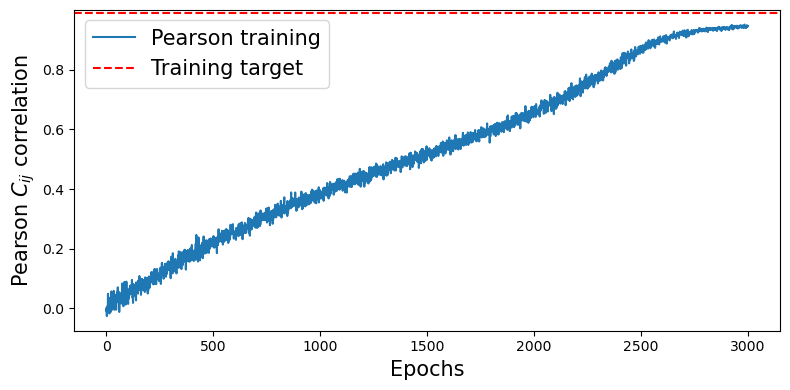

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=100)
ax.plot(history["epochs"], history["pearson"], label="Pearson training")
ax.axhline(target, ls="--", color="red", label="Training target")
ax.set_xlabel("Epochs", fontsize=15)
ax.set_ylabel(r"Pearson $C_{ij}$ correlation", fontsize=15)
ax.legend(fontsize=15)
fig.tight_layout()

<IPython.core.display.Latex object>

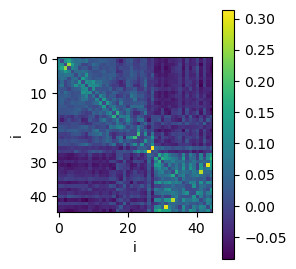

In [14]:
from IPython.display import display, Latex

J_, h_ = utils.set_zerosum_gauge(params['coupling_matrix'], params['bias'])

pl, ax = plt.subplots(figsize=(3,3))
F = selex_dca.get_contact_map(J_)
im = ax.imshow(F)
ax.set_xlabel("i"); ax.set_ylabel("i")
plt.colorbar(im)
plt.tight_layout()
display(Latex("$F_{ij}=\\sqrt {\\sum_{ab}(J_{ij}^{ab})^2}$"))